# Medical Insurance Cost Prediction

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore', category = UserWarning)

### Loading the dataset

In [2]:
df = pd.read_csv('C:/Users/Souridya/Downloads/insurance.csv')

In [3]:
# Display the first 5 rows of the dataset
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# Display the number of rows and columns of the dataset
df.shape

(1338, 7)

In [5]:
# to display the information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### Data Preprocessing

In [6]:
print('Unique values count\n')
print(df.nunique())

Unique values count

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64


In [7]:
# checking for duplicates
df.duplicated().any()

True

In [8]:
# remove the duplicates
df = df.drop_duplicates()
df.shape

(1337, 7)

In [9]:
# checking for any missing values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [10]:
# statistical measures of the dataset
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


### EDA to detect outliers and analyze the data accordingly

C:\Users\Souridya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


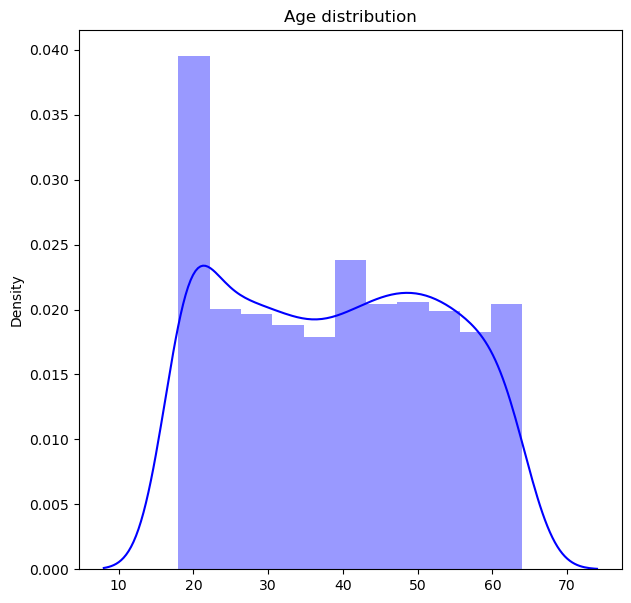

In [11]:
# distribution of age value
plt.figure(figsize=(7,7))
sns.distplot(x =df['age'],color= 'blue')
plt.title('Age distribution')
plt.show()

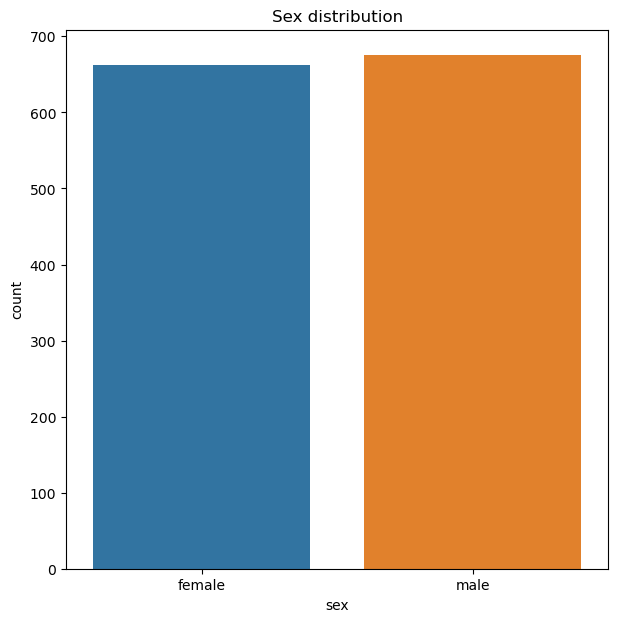

In [12]:
# Categories of sex
plt.figure(figsize=(7,7))
sns.countplot(x='sex',data = df)
plt.title('Sex distribution')
plt.show()

In [13]:
df['sex'].value_counts()

sex
male      675
female    662
Name: count, dtype: int64

C:\Users\Souridya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


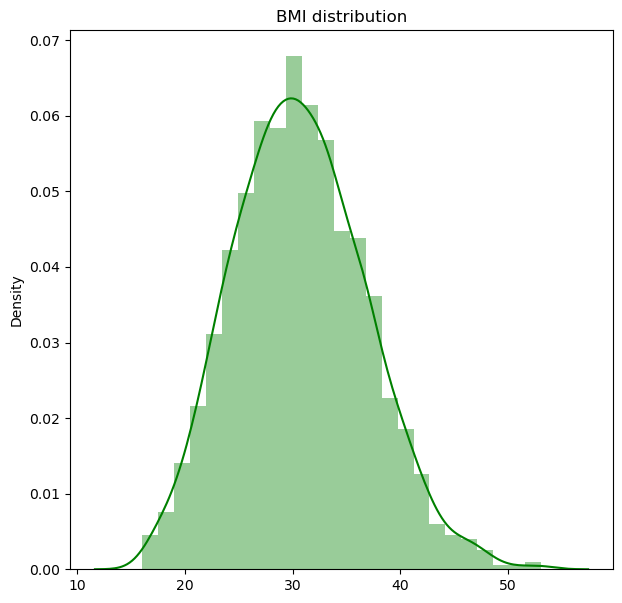

In [14]:
# distribution of BMI
plt.figure(figsize=(7,7))
sns.distplot(x = df['bmi'], color = 'green')
plt.title('BMI distribution')
plt.show()

##### Normal BMI range: 18.5-24.9

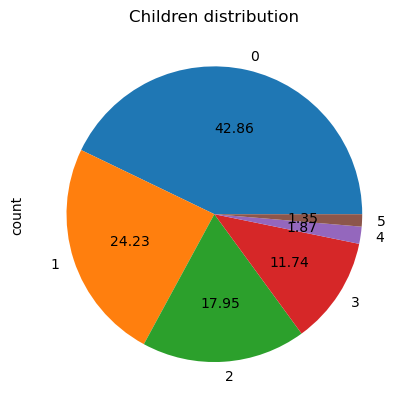

In [15]:
# Categories of number of Children
df['children'].value_counts().plot(kind = 'pie', autopct = '%0.2f')
plt.title('Children distribution')
plt.show()

In [16]:
df['children'].value_counts()

children
0    573
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64

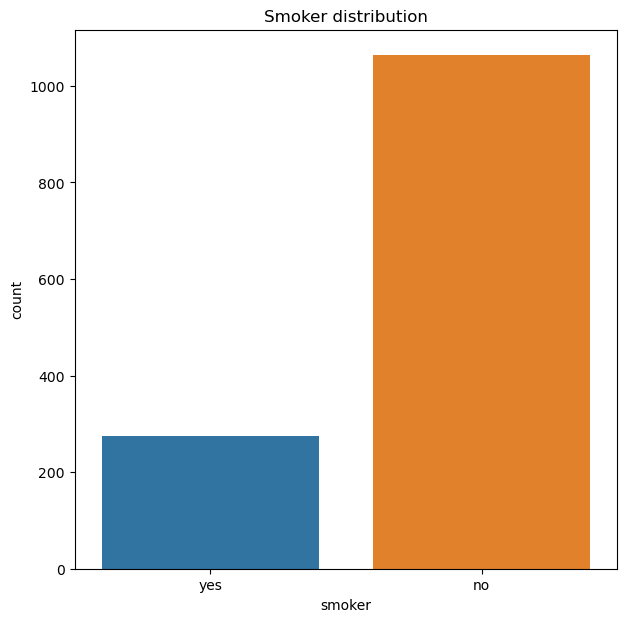

In [17]:
# Categories of Smoker
plt.figure(figsize=(7,7))
sns.countplot(x='smoker', data = df)
plt.title('Smoker distribution')
plt.show()

In [18]:
df['smoker'].value_counts()

smoker
no     1063
yes     274
Name: count, dtype: int64

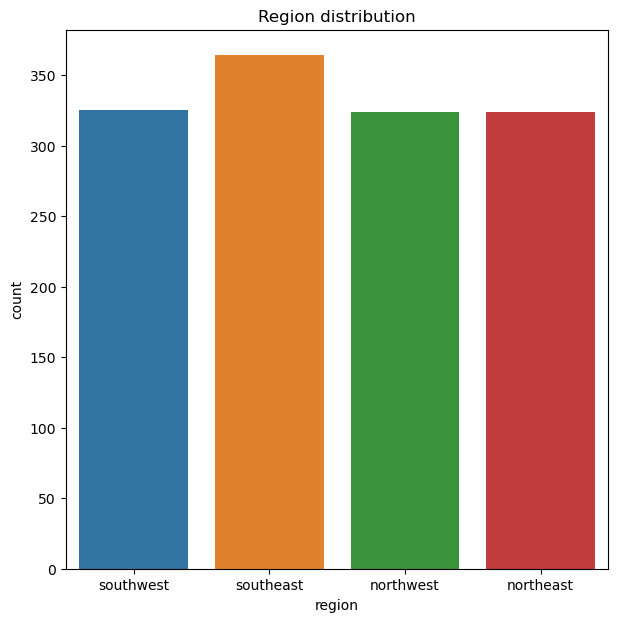

In [19]:
# Categories of Regions
plt.figure(figsize=(7,7))
sns.countplot(x = 'region', data = df)
plt.title('Region distribution')
plt.show()

In [20]:
df['region'].value_counts()

region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64

C:\Users\Souridya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 700x700 with 0 Axes>

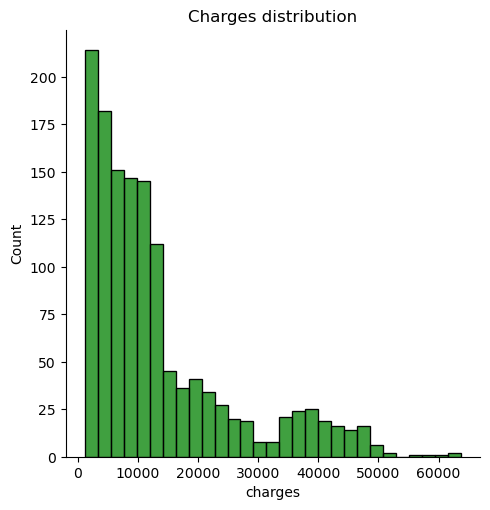

In [21]:
# distribution of charges
plt.figure(figsize=(7,7))
sns.displot(x = 'charges',data = df,color='green')
plt.title('Charges distribution')
plt.show()

##### Our target column 'Charges' is right-skewed

<Axes: xlabel='charges'>

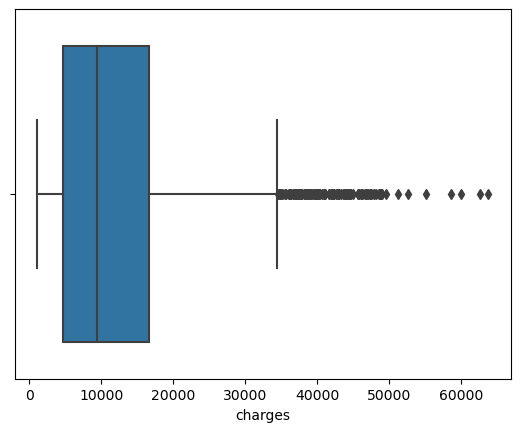

In [22]:
sns.boxplot( data = df, x = 'charges')

### Feature Engineering

In [23]:
# Separating predictor variables and target variable
X = df.drop( columns = 'charges', axis = 1)
y = pd.DataFrame(df['charges'])

In [24]:
# Splitting the data into training/testting dataset
X_train, X_test, y_train, y_test = train_test_split ( X, y, test_size = 0.2, random_state = 42)

In [25]:
X_train.head()

,age,sex,bmi,children,smoker,region
1114,23,male,24.510,0,no,northeast
968,21,male,25.745,2,no,northeast
599,52,female,37.525,2,no,northwest
170,63,male,41.470,0,no,southeast
275,47,female,26.600,2,no,northeast


In [26]:
y_train.head()

,charges
1114,2396.09590
968,3279.86855
599,33471.97189
170,13405.39030
275,9715.84100


In [27]:
# Using Column Transformer
transformer = ColumnTransformer( transformers=[
                        ('tnf1', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore', drop = 'first'),['sex', 'smoker', 'region'])
                        ],remainder = 'passthrough')

In [28]:
X_train = transformer.fit_transform(X_train)

In [29]:
X_train.shape

(1069, 8)

In [30]:
X_test = transformer.transform(X_test)

In [31]:
X_test.shape

(268, 8)

In [32]:
scaler = MinMaxScaler()

In [33]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
# Converting the numpy array to a Dataframe
X_train = pd.DataFrame(X_train, columns = ['Age','OHE_Sex', 'BMI', 'Children', 'OHE_Smoker', 'OHE_Region_1', 'OHE_Region_2', 'OHE_Region_3'])
X_test = pd.DataFrame(X_test, columns = ['Age','OHE_Sex', 'BMI', 'Children', 'OHE_Smoker', 'OHE_Region_1', 'OHE_Region_2', 'OHE_Region_3'])

In [35]:
X_train.head(10)

,Age,OHE_Sex,BMI,Children,OHE_Smoker,OHE_Region_1,OHE_Region_2,OHE_Region_3
0,1.0,0.0,0.0,0.0,0.0,0.108696,0.230024,0.0
1,1.0,0.0,0.0,0.0,0.0,0.065217,0.263250,0.4
2,0.0,0.0,1.0,0.0,0.0,0.739130,0.580172,0.4
3,1.0,0.0,0.0,1.0,0.0,0.978261,0.686306,0.0
4,0.0,0.0,0.0,0.0,0.0,0.630435,0.286252,0.4
5,0.0,0.0,0.0,0.0,1.0,0.500000,0.447673,0.6
6,1.0,0.0,0.0,0.0,0.0,0.478261,0.679849,0.2
7,0.0,0.0,0.0,0.0,0.0,0.913043,0.311811,0.0
8,1.0,0.0,0.0,0.0,0.0,0.347826,0.173796,0.4
9,0.0,0.0,0.0,0.0,1.0,0.847826,0.111380,0.2


### Model Training and Evaluation

##### Linear Regression

In [36]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("MSE:", mean_squared_error(y_test, y_pred_lr))
print("R2 score:", r2_score(y_test, y_pred_lr))
print("Mean R2 score after cross validating:", np.mean(cross_val_score(lr, X_train, y_train, scoring = 'r2')))

MAE: 4177.045561036318
MSE: 35478020.67523556
R2 score: 0.8069287081198014
Mean R2 score after cross validating: 0.7257573536108111


##### Ridge Regression

In [37]:
# Hyperparameter tuning for Ridge Regression
param_grid_rr = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],  # Values of alpha to try
    'fit_intercept': [True, False],           # Whether to calculate the intercept
}

rr_grid = GridSearchCV(Ridge(), param_grid_rr, cv=5,n_jobs = -1)
rr_grid.fit(X_train, y_train)

print(rr_grid.best_params_)

{'alpha': 1, 'fit_intercept': True}


In [38]:
# Model Evaluation Ridge Regression
rr = Ridge(alpha=1, fit_intercept = True)
rr.fit(X_train, y_train)
y_pred_rr = rr.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred_rr))
print("MSE:", mean_squared_error(y_test, y_pred_rr))
print("R2 score:", r2_score(y_test, y_pred_rr))
print("Mean R2 score after cross validating:", np.mean(cross_val_score(rr, X_train, y_train, scoring = 'r2')))

MAE: 4182.26343068578
MSE: 35786555.02496396
R2 score: 0.8052496650289601
Mean R2 score after cross validating: 0.7258151134236916


##### Lasso Regression

In [39]:
# Hyperparameter tuning for Lasso Regression
param_grid_las = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],  # Values of alpha to try
    'fit_intercept': [True, False],
    'max_iter': [1000, 5000, 10000]           # Sometimes Lasso needs more iterations to converge
}
las_grid = GridSearchCV(Lasso(), param_grid_las, cv=5, n_jobs = -1)
las_grid.fit(X_train, y_train)

print(las_grid.best_params_)

{'alpha': 10, 'fit_intercept': True, 'max_iter': 1000}


In [40]:
# Model Evaluation with Lasso Regression
las = Lasso(alpha = 10, fit_intercept = True, max_iter = 1000)
las.fit(X_train, y_train)
y_pred_las = las.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred_las))
print("MSE:", mean_squared_error(y_test, y_pred_las))
print("R2 score:", r2_score(y_test, y_pred_las))
print("Mean R2 score after cross validating:", np.mean(cross_val_score(las, X_train, y_train, scoring = 'r2')))

MAE: 4172.536572686882
MSE: 35716139.31757299
R2 score: 0.8056328671167847
Mean R2 score after cross validating: 0.7258216995701635


##### Decision Tree Regressor

In [41]:
# Hyperparameter tuning for Decision Tree Regressor
param_grid_dt = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30]
}
dt_grid = GridSearchCV(DecisionTreeRegressor(), param_grid_dt, cv=5, n_jobs = -1)
dt_grid.fit(X_train, y_train)

print(dt_grid.best_params_)

{'max_depth': 5, 'max_features': None, 'max_leaf_nodes': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [42]:
# Model Evaluation with Decision Tree Regressor
dt = DecisionTreeRegressor(max_depth = None, max_features = None, max_leaf_nodes = 10, min_samples_leaf = 1, min_samples_split = 2)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
print("MAE:", mean_absolute_error(y_test, dt_pred))
print("MSE:", mean_squared_error(y_test, dt_pred))
print("R2 score:", r2_score(y_test, dt_pred))
print("Mean R2 score after cross validating:", np.mean(cross_val_score(dt, X_train, y_train, scoring = 'r2')))

MAE: 2665.715930308502
MSE: 18841471.61796279
R2 score: 0.8974647627751285
Mean R2 score after cross validating: 0.8229582824066897


##### Random Forest Regressor

In [43]:
# Hyperparameter tuning for Random Forest Regressor
param_grid_rf = {
    'n_estimators': [5, 10, 20, 60, 100, 120],
    'max_samples': [0.5, 0.75, 1.0],
    'max_features': [0.2, 0.6, 1.0],
    'max_depth': [2, 8, 10]
}
rf_grid = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5, n_jobs = -1)
rf_grid.fit(X_train, y_train)

print(rf_grid.best_params_)

{'max_depth': 8, 'max_features': 0.6, 'max_samples': 1.0, 'n_estimators': 100}


In [44]:
# Random Forest Regressor
rf = RandomForestRegressor(max_depth = 2, max_features = 1.0, max_samples = 0.5, n_estimators = 120)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("MAE:", mean_absolute_error(y_test, rf_pred))
print("MSE:", mean_squared_error(y_test, rf_pred))
print("R2 score:", r2_score(y_test, rf_pred))
print("Mean R2 score after cross validating:", np.mean(cross_val_score(rf, X_train, y_train, scoring = 'r2')))

MAE: 3152.08758896384
MSE: 23943536.17626323
R2 score: 0.8696993413457748
Mean R2 score after cross validating: 0.8163736562138924


##### Support Vector Regressor

In [45]:
# Hyperparameter tuning for SVR
param_grid_svr = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly']
}

svr_grid = GridSearchCV(SVR(), param_grid_svr, cv=5, n_jobs = -1)
svr_grid.fit(X_train, y_train)

print(svr_grid.best_params_)

{'C': 100, 'epsilon': 1, 'gamma': 'scale', 'kernel': 'poly'}


In [46]:
# Model Evaluation with Support Vector Regressor
svr = SVR(C=100, epsilon = 1, gamma = 'scale', kernel = 'poly')
svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)
print("MAE:", mean_absolute_error(y_test, svr_pred))
print("MSE:", mean_squared_error(y_test, svr_pred))
print("R2 score:", r2_score(y_test, svr_pred))
print("Mean R2 score after cross validating:", np.mean(cross_val_score(svr, X_train, y_train, scoring = 'r2')))

MAE: 3735.373059459352
MSE: 48316983.85824265
R2 score: 0.7370591054484279
Mean R2 score after cross validating: 0.6857336823279374


##### XGBoost Regressor

In [47]:
# Hyperparameter tuning for XGBRegressor
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.1, 0.5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.01, 0.1, 1]
}

xgb_grid = GridSearchCV(XGBRegressor(), param_grid_xgb, cv=5, n_jobs = -1)
xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_params_)

{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.01, 'reg_lambda': 1}


In [48]:
# Model Evaluation with XGBoost Regressor
xgb = XGBRegressor(gamma = 0, learning_rate = 0.01, max_depth = 3, n_estimators = 500, reg_alpha = 0.01, reg_lambda = 1)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
print("MAE:", mean_absolute_error(y_test, xgb_pred))
print("MSE:", mean_squared_error(y_test, xgb_pred))
print("R2 score:", r2_score(y_test, xgb_pred))
print("Mean R2 score after cross validating:", np.mean(cross_val_score(xgb, X_train, y_train, scoring = 'r2')))

MAE: 2476.306791102845
MSE: 18007309.20237008
R2 score: 0.9020042723687066
Mean R2 score after cross validating: 0.845495051792426


##### Gradient Boosting Regressor

In [49]:
# Hyperparameter tuning for Gradient Boosting regressor
param_grid_gb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

gb_grid = GridSearchCV(GradientBoostingRegressor(), param_grid_gb, cv=5, n_jobs = -1)
gb_grid.fit(X_train, y_train)

print(gb_grid.best_params_)

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}


In [50]:
# Model Evaluation with Gradient Boosting Regressor
gb = GradientBoostingRegressor(learning_rate = 0.01, max_depth = 3, n_estimators = 500)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
print("MAE:", mean_absolute_error(y_test, gb_pred))
print("MSE:", mean_squared_error(y_test, gb_pred))
print("R2 score:", r2_score(y_test, gb_pred))
print("Mean R2 score after cross validating:", np.mean(cross_val_score(gb, X_train, y_train, scoring = 'r2')))

MAE: 2504.1052022961017
MSE: 18286366.66458315
R2 score: 0.9004856424194351
Mean R2 score after cross validating: 0.8430086442775606


##### Stacking 

In [51]:
estimators = [
    ('dt', dt),
    ('gb', gb),
    ('rf', rf),
    ('xgb', xgb),
    ('svr', svr)
]

In [52]:
stck = StackingRegressor(
    estimators=estimators, 
    final_estimator = lr,
    cv=10
)

In [53]:
stck.fit(X_train, y_train)

StackingRegressor(cv=10,
                  estimators=[('dt', DecisionTreeRegressor(max_leaf_nodes=10)),
                              ('gb',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         n_estimators=500)),
                              ('rf',
                               RandomForestRegressor(max_depth=2,
                                                     max_samples=0.5,
                                                     n_estimators=120)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_by...
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('svr', SVR(C=100, epsilon=1, kernel='poly'))],
                  final_estimator=LinearRegression())

In [54]:
y_pred = stck.predict(X_test)

In [55]:
print("R2 score:", r2_score(y_test, y_pred))

R2 score: 0.9008093903565627
